In [1]:
%matplotlib notebook

import os

import tensorflow as tf
from tensorflow import keras

import numpy as np
import scipy as sp
import nibabel as nib
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import lib.motion as motion

In [2]:
n = 64
batch_size = 100

# Set up model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
model.load_weights('training/automap64-clean-long/cp-0380.ckpt')

In [3]:
# Set up model
brain_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
brain_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
brain_model.load_weights('training/automap64-brain-clean/cp-0375.ckpt')

In [4]:
# Set up corrupted model
corrupted_3_15_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
corrupted_3_15_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
corrupted_3_15_model.load_weights('training/automap64-3px-k15-pretrain/cp-0200.ckpt')

In [5]:
# Set up corrupted model
corrupted_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
corrupted_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
corrupted_model.load_weights('training/automap64-random/cp-0200.ckpt')

In [6]:
# Set up corrupted pretrained model
corrupted_all_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
corrupted_all_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
corrupted_all_model.load_weights('training/automap64-random-trans-and-rot/cp-0245.ckpt')

In [7]:
def get_plotting_data(angle,num_pix,k_line,data_dir,ind):
    data_path = data_dir+os.listdir(data_dir)[ind]
    vol_data = np.load(data_path)['vol_data']
    _,_,z = vol_data.shape

    img_data = vol_data[:,:,int(z/2)]
    img_data = np.array(Image.fromarray(img_data).resize((n,n)))
    img_data = img_data-img_data.mean()
    img_data = img_data/np.max(img_data)

    corrupted_img,corrupted_k_raw = motion.add_rotation_and_translation(img_data,angle,num_pix,k_line,return_k=True)

    corrupted_k_all = np.expand_dims(corrupted_k_raw,-1)
    corrupted_k_re = np.real(corrupted_k_all)
    corrupted_k_im = np.imag(corrupted_k_all)
    corrupted_k = np.expand_dims(np.concatenate([corrupted_k_re,corrupted_k_im], axis=2), axis=0) 
    return img_data, corrupted_img, corrupted_k

<IPython.core.display.Javascript object>


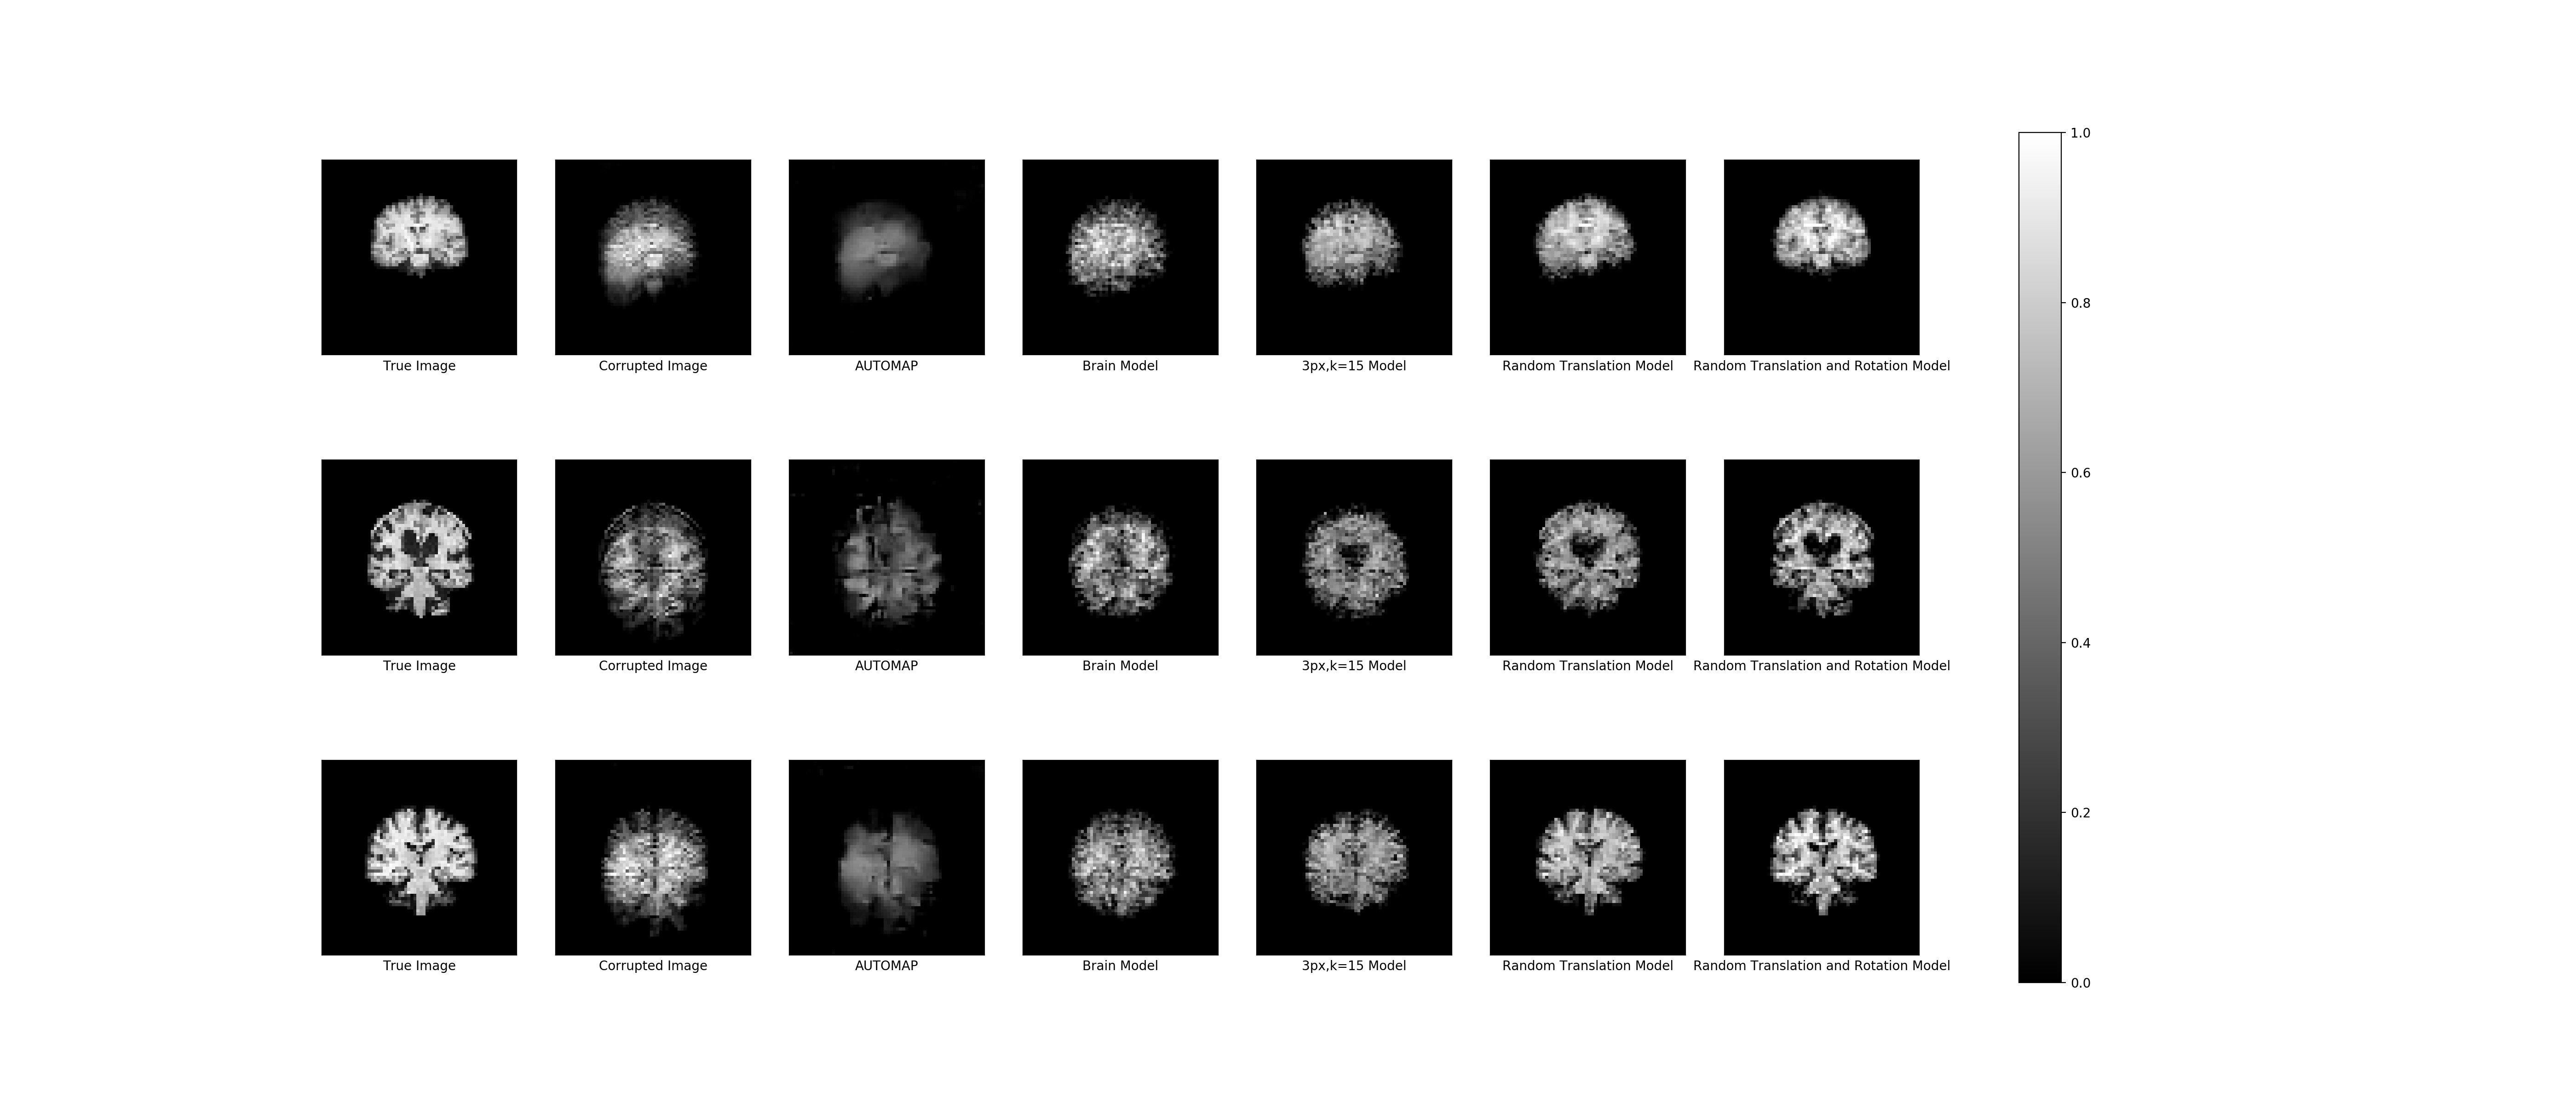

In [8]:
num_imgs = 3
num_pix = 8
angle = 30
k_line = 20

data_dir = '/data/ddmg/voxelmorph/data/t1_mix/proc/old/resize256-crop_0/test/vols/'

fig,axes = plt.subplots( num_imgs,7, figsize=[28,4*num_imgs] )

img_datas = []
corrupted_imgs = []
corrupted_ks = []

for i in range(num_imgs):
    img_data, corrupted_img, corrupted_k = get_plotting_data(angle,num_pix,k_line,data_dir,i)
    img_datas.append(img_data)
    corrupted_imgs.append(corrupted_img)
    corrupted_ks.append(corrupted_k)

for i,iax in enumerate(axes.flatten()):
    subj = int(i/7)
    img_data = img_datas[subj]
    corrupted_img = corrupted_imgs[subj]
    corrupted_k = corrupted_ks[subj]
    
    if i%7==0:
        true_img = np.rot90(img_data, axes=(1,0))
        im = iax.imshow(true_img,cmap='gray')
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('True Image')
    elif i%7==1:
        plot_corrupted_img = np.rot90((np.real(corrupted_img)), axes=(1,0))
        im = iax.imshow(plot_corrupted_img,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Corrupted Image')
    elif i%7==2:
        model_img = np.rot90(model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
        im = iax.imshow(model_img,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('AUTOMAP')
    elif i%7==3:
        model_img = np.rot90(brain_model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
        im = iax.imshow(model_img,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Brain Model')
    elif i%7==4:
        corrupted_3_15_predict = np.rot90(corrupted_3_15_model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
        im = iax.imshow(np.real(corrupted_3_15_predict),cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('3px,k=15 Model')
    elif i%7==5:
        corrupted_predict = np.rot90(corrupted_model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
        im = iax.imshow(corrupted_predict,cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Random Translation Model')
    elif i%7==6:
        corrupted_pretrain_predict = np.rot90(corrupted_all_model.predict(corrupted_k)[0,:,:,0], axes=(1,0))
        im = iax.imshow(np.real(corrupted_pretrain_predict),cmap='gray',vmin=0,vmax=1)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Random Translation and Rotation Model')
        
fig.colorbar(im, ax=axes.ravel().tolist())